In [17]:
# Copyright (C) Nicholas Peatfield, 2021
# Sections taken from Pytorch Tutorial

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
from torch import nn, optim
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# LETS JUST USE THE PYTORCH TUTORIAL DATASET i.e. FASHIONMNIST
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [19]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

def make_acc_dataset(model, dataset):
  n = len(dataset)
  for i in range(n):
      x, y = dataset[i][0], dataset[i][1]
      with torch.no_grad():
          pred = model(x)
      if (not(pred[0].argmax(0) - y)):
          dataset.targets[i] = 1
      else:
          dataset.targets[i] = 0
  return dataset

In [20]:
# Get cpu or gpu device for training.
device = "cpu"
print("Using {} device".format(device))
# Define model
class NeuralNetworkClass(nn.Module):
    def __init__(self):
        super(NeuralNetworkClass, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x).to(device)
        return logits

class_model = NeuralNetworkClass().to(device)
print(class_model)
pred_model = NeuralNetworkClass()
pred_model.linear_relu_stack[4] = nn.Linear(512, 2)
print(pred_model)
print(class_model)

Using cpu device
NeuralNetworkClass(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)
NeuralNetworkClass(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=2, bias=True)
    (5): ReLU()
  )
)
NeuralNetworkClass(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1

In [21]:

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss, correct

def weight_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias)




In [23]:
class EarlyStopping:
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

The index is 0
The index is 1
The index is 1
The index is 3


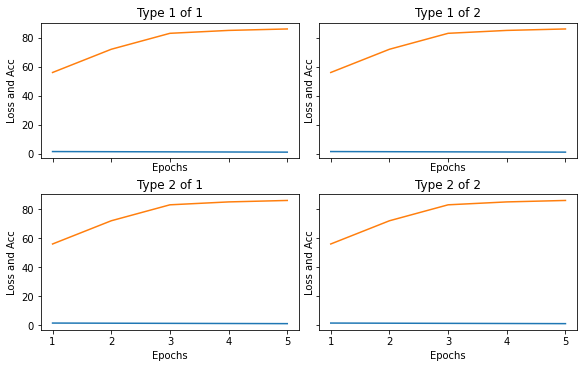

In [36]:
class AccValGraphs:
    """
    Graph class objects to return the m*n
    """
    def __init__(self, model_types=2, model_gen=20, epochs=100):
        """
        :param model_types: how many types of models to plot for e.g. class vs acc
        :param model_gen: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.model_type = model_types
        self.model_gen = model_gen
        self.x = np.linspace(1,epochs,epochs)

        self.fig, self.axs = plt.subplots(model_types, model_gen, figsize=(8, 5), constrained_layout=True,
            sharex=True, sharey=True)


    def add_ax(self,type,gen,val_array,acc_array):
        self.axs[type-1,gen-1].plot(self.x,val_array, self.x, acc_array)
        self.axs[type-1,gen-1].set_title(f'Type {type} of {gen}')
        self.axs[type-1,gen-1].set_xlabel('Epochs')
        self.axs[type-1,gen-1].set_ylabel('Loss and Acc')


graphs = AccValGraphs(model_types=2,model_gen=2,epochs=5)
graphs.add_ax(0,0,[1.5,1.4,1.3,1.2,1.1],[56,72,83,85,86])
graphs.add_ax(1,2,[1.5,1.4,1.3,1.2,1.1],[56,72,83,85,86])
graphs.add_ax(2,1,[1.5,1.4,1.3,1.2,1.1],[56,72,83,85,86])
graphs.add_ax(2,2,[1.5,1.4,1.3,1.2,1.1],[56,72,83,85,86])

New Gen Time 

Epoch 1 of gen 1
-------------------------------
Test Error: 
 Accuracy: 70.4%, Avg loss: 0.968720 

Epoch 2 of gen 1
-------------------------------
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.963800 

Epoch 3 of gen 1
-------------------------------
Test Error: 
 Accuracy: 70.5%, Avg loss: 0.959202 

Epoch 4 of gen 1
-------------------------------
Test Error: 
 Accuracy: 70.6%, Avg loss: 0.954920 

Epoch 5 of gen 1
-------------------------------
Test Error: 
 Accuracy: 70.7%, Avg loss: 0.950906 

Saved PyTorch Model State to 1_allclass_model.pth
The index is 0


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

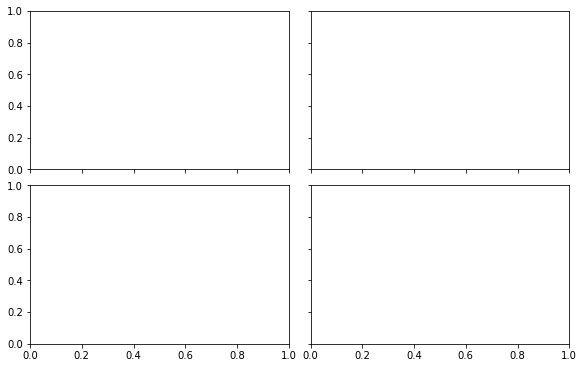

In [33]:
%debug


torch.save(class_model.state_dict(), f"blankallclass_model.pth")
torch.save(pred_model.state_dict(), f"blankpred_model.pth")

epochs = 5
model_gens = 2
graphs_now = AccValGraphs(model_types=2,model_gen=model_gens,epochs=epochs)

for g in range(model_gens):
    # Reset all the models
    # Full 10 class
    print(f"New Gen Time \n")
    class_loss = []
    class_acc = []
    class_model = NeuralNetworkClass()
    class_model.load_state_dict(torch.load("blankallclass_model.pth"))
    class_model.apply(weight_init)
    loss_fn_class = nn.CrossEntropyLoss()
    optimizer_class = torch.optim.SGD(class_model.parameters(), lr=1e-3)
    early_stopping = EarlyStopping(min_delta=0.001)
    for t in range(epochs):
        print(f"Epoch {t+1} of gen {g+1}\n-------------------------------")
        train(train_dataloader, class_model, loss_fn_class, optimizer_class)
        loss_tmp, accu_tmp = test(test_dataloader, class_model, loss_fn_class)
        class_loss.append(loss_tmp)
        class_acc.append(accu_tmp)
        early_stopping(loss_tmp)
        if early_stopping.early_stop or t == epochs-1:
            torch.save(class_model.state_dict(), f"{g+1}_allclass_model.pth")
            print(f"Saved PyTorch Model State to {g+1}_allclass_model.pth")
            graphs_now.add_ax(1,1,[1.5,1.4,1.3,1.2,1.1],[56,72,83,85,86])
            pred_model = NeuralNetworkClass()
            pred_model.linear_relu_stack[4] = nn.Linear(512, 2)
            acc_loss = []
            acc_acc = []
            early_stopping = EarlyStopping(min_delta=0.001)
            loss_fn_pred = nn.CrossEntropyLoss()
            optimizer_pred = torch.optim.SGD(pred_model.parameters(), lr=1e-3)
            print(f"Predicting {g+1}\n-------------------------------")
            pred_train_dataset = make_acc_dataset(class_model,training_data)
            pred_test_dataset = make_acc_dataset(class_model,test_data)
            pred_train_dataloader = DataLoader(pred_train_dataset, batch_size=batch_size)
            pred_test_dataloader = DataLoader(pred_test_dataset, batch_size=batch_size)
            for p in range(epochs):
                print(f"Epoch {p+1} of gen {g+1} pred class \n-------------------------------")
                train(pred_train_dataloader, pred_model, loss_fn_pred, optimizer_pred)
                loss_tmp, acc_tmp= test(pred_test_dataloader, pred_model, loss_fn_pred)
                acc_loss.append(loss_tmp)
                acc_acc.append(acc_tmp)
                early_stopping(loss_tmp)
                if early_stopping.early_stop or p == epochs:
                    torch.save(pred_model.state_dict(), f"{g+1}_pred_model.pth")
                    print(f"Saved PyTorch Model State to {g+1}_pred_model.pth")
                    graphs_now.add_ax(2,1,[1.5,1.4,1.3,1.2,1.1],[56,72,83,85,86])
                    break
            break


print("Done!")

